

Dataset: [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)

#Making a car classifier using Pytorch



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Build model

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla V100-SXM2-16GB


In [5]:
data_path = '/content/drive/My Drive/Colab Notebooks/CNN_Car/Data/car_data/car_data'

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=data_path + '/train', transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=data_path + '/test', transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)

Model training 

In [6]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

Evaluate training data


In [7]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# Start


define parameters

In [8]:
NUM_CAR_CLASSES = 196
model_ft = models.alexnet(pretrained=True)  
# googlenet = models.googlenet(pretrained=True) model.fc.in_features
# resnet34 = models.resnet34(pretrained=True)  model.fc.in_features
# resnet50 = models.resnet50(pretrained=True)  model.fc.in_features

# for alexnet
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for resnet
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


model training

In [9]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 1879 s, loss: 5.2835, acc: 0.5637


  5%|▌         | 1/20 [1:02:50<19:54:08, 3770.99s/it]

Accuracy of the network on the test images: 0 %
Epoch 2, duration: 61 s, loss: 5.2379, acc: 1.1642


 10%|█         | 2/20 [1:04:53<13:22:54, 2676.36s/it]

Accuracy of the network on the test images: 1 %
Epoch 3, duration: 60 s, loss: 4.9450, acc: 3.5294


 15%|█▌        | 3/20 [1:06:53<9:01:02, 1909.56s/it] 

Accuracy of the network on the test images: 5 %
Epoch 4, duration: 60 s, loss: 4.2865, acc: 9.4608


 20%|██        | 4/20 [1:08:55<6:06:12, 1373.27s/it]

Accuracy of the network on the test images: 10 %
Epoch 5, duration: 62 s, loss: 3.7650, acc: 15.4779


 25%|██▌       | 5/20 [1:10:59<4:09:36, 998.41s/it] 

Accuracy of the network on the test images: 14 %
Epoch 6, duration: 61 s, loss: 3.3132, acc: 22.6716


 30%|███       | 6/20 [1:13:00<2:51:34, 735.34s/it]

Accuracy of the network on the test images: 17 %
Epoch 7, duration: 64 s, loss: 2.9931, acc: 28.2353


 35%|███▌      | 7/20 [1:15:07<1:59:44, 552.64s/it]

Accuracy of the network on the test images: 18 %
Epoch 8, duration: 63 s, loss: 2.6939, acc: 33.9093


 40%|████      | 8/20 [1:17:11<1:24:50, 424.24s/it]

Accuracy of the network on the test images: 20 %
Epoch 9, duration: 62 s, loss: 2.4574, acc: 38.9338


 45%|████▌     | 9/20 [1:19:16<1:01:18, 334.37s/it]

Accuracy of the network on the test images: 22 %
Epoch 10, duration: 61 s, loss: 1.0653, acc: 70.4534


 50%|█████     | 10/20 [1:21:16<45:00, 270.09s/it] 

Accuracy of the network on the test images: 33 %
Epoch 11, duration: 62 s, loss: 0.6075, acc: 81.7279


 55%|█████▌    | 11/20 [1:23:21<33:58, 226.50s/it]

Accuracy of the network on the test images: 33 %
Epoch 12, duration: 65 s, loss: 0.4100, acc: 87.4510


 60%|██████    | 12/20 [1:25:26<26:09, 196.13s/it]

Accuracy of the network on the test images: 35 %
Epoch 13, duration: 64 s, loss: 0.2918, acc: 90.7966


 65%|██████▌   | 13/20 [1:27:31<20:22, 174.70s/it]

Accuracy of the network on the test images: 35 %
Epoch 14, duration: 64 s, loss: 0.2158, acc: 93.4559


 70%|███████   | 14/20 [1:29:40<16:05, 161.00s/it]

Accuracy of the network on the test images: 36 %
Epoch 15, duration: 63 s, loss: 0.1582, acc: 95.1838


 75%|███████▌  | 15/20 [1:31:48<12:36, 151.26s/it]

Accuracy of the network on the test images: 36 %
Epoch 16, duration: 64 s, loss: 0.1417, acc: 95.6127


 80%|████████  | 16/20 [1:33:57<09:38, 144.55s/it]

Accuracy of the network on the test images: 36 %
Epoch 17, duration: 66 s, loss: 0.1334, acc: 95.8333


 85%|████████▌ | 17/20 [1:36:09<07:01, 140.65s/it]

Accuracy of the network on the test images: 37 %
Epoch 18, duration: 65 s, loss: 0.1336, acc: 95.6618


 90%|█████████ | 18/20 [1:38:20<04:35, 137.93s/it]

Accuracy of the network on the test images: 37 %
Epoch 19, duration: 64 s, loss: 0.1216, acc: 96.2990


 95%|█████████▌| 19/20 [1:40:32<02:16, 136.06s/it]

Accuracy of the network on the test images: 37 %
Epoch 20, duration: 65 s, loss: 0.1179, acc: 96.3480


100%|██████████| 20/20 [1:42:43<00:00, 308.20s/it]

Accuracy of the network on the test images: 37 %
Finished Training


Text(0.5, 1.0, 'Test Accuracy')

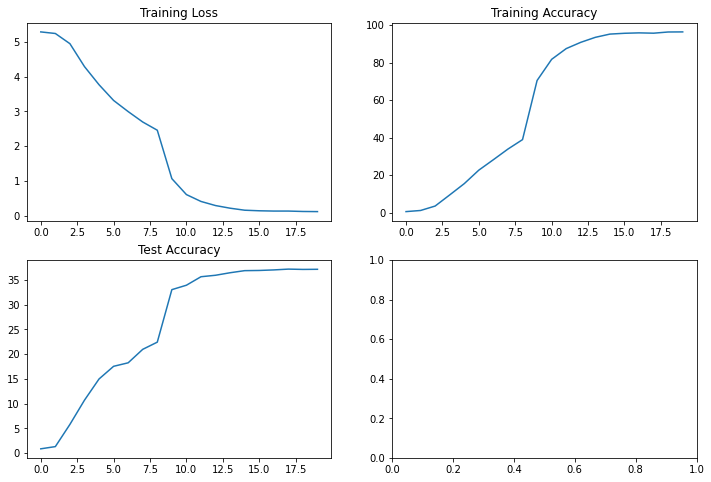

In [10]:
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training Loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training Accuracy")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test Accuracy")

Evaluate the model on single images 



In [12]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_path+"/train")

test the model on random images

In [14]:
model_ft.eval()

loader = transforms.Compose([transforms.Resize((400, 400)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(data_path+"/test/BMW X3 SUV 2012/00064.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

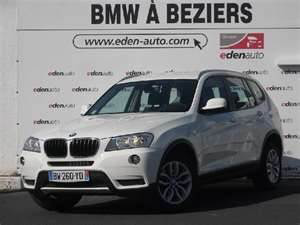

Ford Mustang Convertible 2007 confidence:  9.749861717224121


In [16]:

display(Image.open(data_path+"/test/BMW X3 SUV 2012/00064.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

Save and load model

In [17]:
PATH = 'car_model.pth'
torch.save(model_ft.state_dict(), PATH)

In [18]:
model_loaded = torch.load(PATH)
model_loaded


OrderedDict([('features.0.weight',
              tensor([[[[ 1.0392e-01,  7.4414e-02,  7.8374e-02,  ...,  4.4130e-02,
                          2.1039e-02,  6.7703e-02],
                        [ 6.3684e-02,  1.5507e-02,  4.0997e-02,  ...,  1.3470e-02,
                         -1.5420e-02,  8.8519e-03],
                        [ 6.8046e-02,  1.9947e-02,  4.4943e-02,  ...,  3.9119e-02,
                          2.2454e-03,  7.3498e-03],
                        ...,
                        [ 8.3662e-02,  8.6426e-02,  6.2155e-02,  ..., -2.1485e-01,
                         -1.2940e-01, -9.7701e-02],
                        [ 4.3110e-02,  5.7952e-02,  4.8806e-02,  ..., -1.9374e-01,
                         -9.7966e-02, -7.5926e-02],
                        [ 4.8610e-02,  5.9344e-02,  6.0557e-02,  ..., -1.0113e-01,
                         -6.4153e-02, -3.6313e-02]],
              
                       [[-5.9363e-02, -5.2734e-02, -7.6893e-02,  ..., -8.2074e-03,
                         -2